#### SST (DJF) trend in CESM-HR over the period 1980-2020
- Read HIST
- Read RCP85
- Seasonal average
- Calculate trend
- Plotting
 
Ming Ge April 2025

In [1]:
import glob
import os
from pathlib import Path
import numpy as np
import xarray as xr
import uxarray as ux 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import ticker, cm
import matplotlib.tri as tri
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import warnings 
import geoviews.feature as gf
import geoviews as gv
from geoviews import opts
import holoviews as hv
hv.extension("matplotlib")
warnings.filterwarnings("ignore")

#### Define some functions

#### Read HIST

In [2]:
%%time
dir_o  = '/glade/campaign/mmm/c3we/mingge/CESM-HR/'
flnm_o = dir_o + 'TsTrend_DJF_1980-2020.nc'

n_mem = 10

year_s = 1980
year_e = 2020
n_year = year_e - year_s + 1

# Monthly Dec SST timed as 01-01
# Dec. Jan Feb
selected_months = [1, 2, 3]  
n_mon = len(selected_months)
start_date = str(year_s) + '-01-01'
end_date   = str(year_e) + '-03-01'

dir_hr = '/glade/campaign/collections/rda/data/d651007/'

name_0 = 'b.e13.BHISTC5.ne120_t12.cesm-ihesp-'
name_1 = '-1920-2005.'

period_1d = ['197001-197912','198001-198912', '199001-199912', '200001-200512']
n_period = len(period_1d)

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    is_first = True
    for nm in range(n_mem):
        if nm == 0:
            member_name = name_0 + 'sehires38-1850-2005.001'
        elif nm==1 or nm==2:
            member_name = name_0 + 'hires1.0.30' + name_1 + str(nm+1).zfill(3)
        elif nm==3 or nm==4:
            member_name = name_0 + 'hires1.0.44' + name_1 + str(nm+1).zfill(3)
        elif nm==5:
            member_name = name_0 + 'hires1.0.45' + name_1 + str(nm+1).zfill(3)
        else:
            member_name = name_0 + 'hires1.0.46' + name_1 + str(nm+1).zfill(3)

        dir_0 = dir_hr + member_name + '/atm/proc/tseries/month_1/'
        nmon_s = 0
        for nn in range(n_period):
            
            flnm = dir_0 + member_name + \
                '.cam.h0.TS.'+ period_1d[nn] + '.nc'
            
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                #print(ds.TS)
                
                # select data corresponding to selected_months
                ts = ds.TS.sel(time=ds.time.dt.month.isin(selected_months)) \
                            .sel(time=slice(None, end_date))\
                            .sel(time=slice(start_date, None))
                nmon_e = nmon_s + ts.shape[0]
                 
                if is_first == True:
                    n_col = ts.shape[1]
                    data_3d = np.zeros((n_mem, n_year*n_mon, n_col))
                    is_first = False
                
                print(nmon_s,' - ', nmon_e, ts.shape)
                data_3d[nm, nmon_s:nmon_e] = ts
                nmon_s=nmon_e
          

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1980-2020.nc exist
CPU times: user 201 μs, sys: 0 ns, total: 201 μs
Wall time: 205 μs


#### Read CESM HR RCP85 (2006-2100) simulations.

In [3]:
%%time
dir_hr = '/glade/campaign/collections/rda/data/d651009/'

name_0 = 'b.e13.BRCP85C5.ne120_t12.cesm-ihesp-'
name_1 = '-2006-2100.'

period_1d = ['200601-201512', '201601-202512']
n_period = len(period_1d)

if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    is_first = True
    for nm in range(n_mem):
        if nm == 0:
            member_name = name_0 + 'sehires38' + name_1 + str(nm+1).zfill(3)
        elif nm==1:
            member_name = name_0 + 'hires1.0.30' + name_1 + str(nm+1).zfill(3)
        elif nm==2:
            member_name = name_0 + 'hires1.0.31' + name_1 + str(nm+1).zfill(3)
        elif nm==4 or nm==3:
            member_name = name_0 + 'hires1.0.44' + name_1 + str(nm+1).zfill(3)
        else:
            member_name = name_0 + 'hires1.0.46' + name_1 + str(nm+1).zfill(3)

        dir_0 = dir_hr + member_name + '/atm/proc/tseries/month_1/'
        nmon_s = 79
        for nn in range(n_period):
            flnm = dir_0 + member_name + \
                '.cam.h0.TS.'+ period_1d[nn] + '.nc'
            
            with xr.open_dataset(flnm) as ds:
                print(flnm)
                # select data corresponding to selected_months
                ts = ds.TS.sel(time=ds.time.dt.month.isin(selected_months)) \
                            .sel(time=slice(None, end_date))
                nmon_e = nmon_s + ts.shape[0]

                print(nmon_s,nmon_e)
                data_3d[nm, nmon_s:nmon_e] = ts
                nmon_s=nmon_e


/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1980-2020.nc exist
CPU times: user 180 μs, sys: 0 ns, total: 180 μs
Wall time: 184 μs


#### seasonal average

In [4]:
if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    # 3 months average
    # ts_3d = np.zeros((n_mem, n_year*n_mon, n_col))
    ts_3d = np.zeros((n_mem, n_year, n_col))
    nn = 0
    n_s = 0
    for ny in range(n_year):        
        n_e = n_s + 3
        ts_3d[:,ny] = np.mean(data_3d[:,n_s:n_e], axis=1) 
        nn =+ 1
        n_s = n_e

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1980-2020.nc exist


#### Calculate trend

In [5]:
%%time
if os.path.isfile(flnm_o):
    print(flnm_o, 'exist')
else:
    # Fill value -99
    trend_2d = np.zeros((n_mem, n_col)) - 99
    # Time vector for regression
    tt = np.arange(n_year)

    # Loop over mem, lat-lon grid and fit a linear trend
    for nm in range(n_mem):
        print(nm)
        for ii in range(n_col):
            yy = ts_3d[nm, :, ii]
            # Fit line: degree=1 returns [slope, intercept]
            slope, intercept = np.polyfit(tt, yy, 1)
            trend_2d[nm, ii] = slope  # Save the trend (slope)

    # Create the DataArray
    trend_da = xr.DataArray(
        trend_2d,
        dims=['member', 'ncol'],
        name='ts_trend'
    )

    # Combine into a Dataset
    ds = xr.Dataset({
        "ts_trend": trend_da,
        "lat": ds.lat,
        "lon": ds.lon
    })

    ds.to_netcdf(flnm_o)

/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1980-2020.nc exist
CPU times: user 172 μs, sys: 0 ns, total: 172 μs
Wall time: 175 μs


#### Plotting

:Overlay
   .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
   .Land.I      :Feature   [Longitude,Latitude]
   .Lines.I     :Feature   [Longitude,Latitude]
   .Borders.I   :Feature   [Longitude,Latitude]
   .Coastline.I :Feature   [Longitude,Latitude]
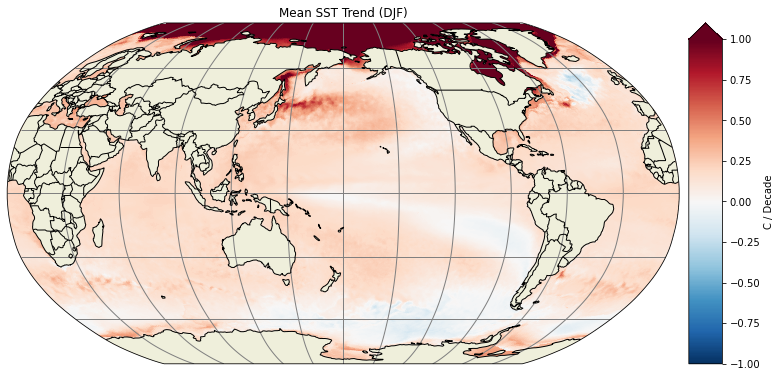

In [16]:
grid_base_path = "/glade/p/cesmdata/cseg/inputdata/share/meshes/"
grid_file_name = "ne120np4_ESMFmesh_cdf5_c20211018.nc"
grid_path = grid_base_path + grid_file_name

# Open a dataset (match the grid to the data)
uxds = ux.open_dataset(grid_path, flnm_o)
ts_trend = 10*uxds.ts_trend.mean(dim='member') 

projection = ccrs.Robinson(central_longitude=180)

graticules = cfeature.NaturalEarthFeature(
    category='physical',
    name='graticules_30',
    scale='110m')

# Land, Borders, Coastlines and Graticules 
features = (gf.land() * gv.Feature(graticules, group='Lines') * gf.borders * gf.coastline).opts(
    opts.Feature('Lines', projection=projection, facecolor='none', edgecolor='gray'))

# A simple and reliable way to control the colorbar label in hvplot (Bokeh) is to rename the data variable
ts_trend = ts_trend.rename("C / Decade")
ts_trend.plot(
    backend='matplotlib', projection=projection, 
    #colorbar=True,
    title="Mean SST Trend (DJF)", clim=(-1, 1), cmap="RdBu_r", pixel_ratio=4.0, width=1000, height=500, 
) * features

In [ ]:
dir_o  = '/glade/campaign/mmm/c3we/mingge/CESM-HR/'
flnm_o = '/glade/campaign/mmm/c3we/mingge/CESM-HR/TsTrend_DJF_1980-2020.nc'

grid_base_path = "/glade/p/cesmdata/cseg/inputdata/share/meshes/"
grid_file_name = "ne120np4_ESMFmesh_cdf5_c20211018.nc"
grid_path = grid_base_path + grid_file_name

# Open a dataset (match the grid to the data)
uxds = ux.open_dataset(grid_path, flnm_o)

# Plot the first time step of TS
ts_trend = 10*uxds.ts_trend 
ts_trend = ts_trend.rename("C / Decade")

projection = ccrs.Robinson(central_longitude=180)

graticules = cfeature.NaturalEarthFeature(
    category='physical',
    name='graticules_30',
    scale='110m')

# Land, Borders, Coastlines and Graticules 
features = (gf.land() * gv.Feature(graticules, group='Lines') * gf.coastline).opts(
    opts.Feature('Lines', projection=projection, facecolor='none', edgecolor='none'))

plot_1 = []
for ii in range(10):
    plot_1.append(ts_trend[ii].plot(backend='matplotlib', 
                                    projection=projection, 
                                    #colorbar=True,
                                    title='SST (member' + str(ii + 1) + ')', 
                                    clim=(-1, 1), cmap="RdBu_r", 
                                    pixel_ratio=4.0, width=800, height=400) 
                                    * features )

:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.V    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VI   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VII  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VIII :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IX   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.X    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
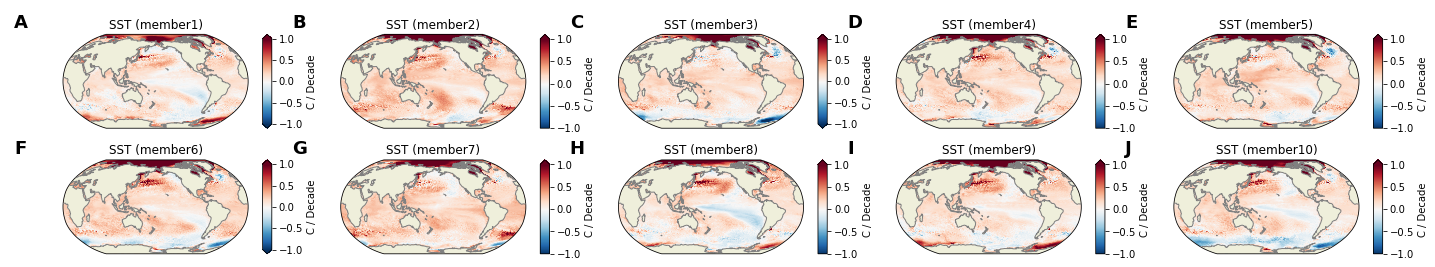

In [31]:
layout = hv.Layout(plot_1).cols(5)
layout

:Layout
   .Overlay.I    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.II   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.III  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IV   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.V    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VI   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VII  :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.VIII :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.IX   :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
   .Overlay.X    :Overlay
      .Image.I     :Image   [Longitude,Latitude]   (Longitude_Latitude C / Decade)
      .Land.I      :Feature   [Longitude,Latitude]
      .Lines.I     :Feature   [Longitude,Latitude]
      .Coastline.I :Feature   [Longitude,Latitude]
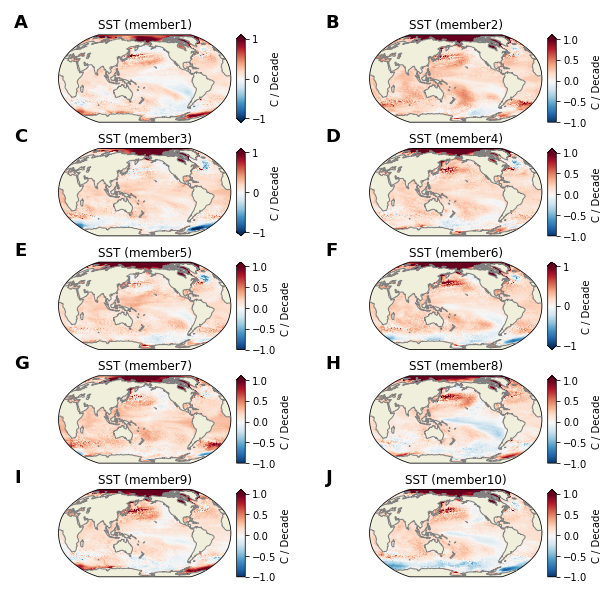

In [30]:
layout = hv.Layout(plot_1).cols(2)
layout